## Setting Up

In [ ]:
!pip install video-kf
!pip install katna

     |████████████████████████████████| 40kB 2.5MB/s 
     |████████████████████████████████| 389kB 8.3MB/s 
     |████████████████████████████████| 26.9MB 112kB/s 
  Created wheel for moviepy: filename=moviepy-1.0.3-cp36-none-any.whl size=110729 sha256=edf372a36375fda893bd15ba7d1ae4a3443e16e7b9cebecd663e9a622230ca0b
  Stored in directory: /root/.cache/pip/wheels/e0/fe/1c/f4e6dca9e828d4b979c04e461d7fcc5b8e7bd35f947e665b65
  Created wheel for proglog: filename=proglog-0.1.9-cp36-none-any.whl size=6149 sha256=e4a37494e0018bb132477540e536516685f6e0b10aaa4bb0226763f133284faa
  Stored in directory: /root/.cache/pip/wheels/65/56/60/1d0306a8d90b188af393c1812ddb502a8821b70917f82dcc00
Successfully built moviepy proglog
ERROR: moviepy 1.0.3 has requirement imageio<3.0,>=2.5; python_version >= "3.4", but you'll have imageio 2.4.1 which is incompatible.
  Found existing installation: moviepy 0.2.3.5
    Uninstalling moviepy-0.2.3.5:
      Successfully uninstalled moviepy-0.2.3.5


In [ ]:
#Importing Libraries

import argparse
import os
import random
import shutil
import time
import warnings
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from Katna.video import Video

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##KEY FRAME EXTRACTION


In [ ]:
import matplotlib.pyplot as plt
import shutil
import os 
from Katna.video import Video
import torch
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
try:
  os.mkdir("/content/Image_Data")
except:
  pass

In [ ]:
########### KEY FRAME EXTRACTION ###########
base = "/content/drive/My Drive/Action_Recognition/Training"                                                               # Base  path
dest = "/content/drive/My Drive/Action_Recognition/Image_Data"
counter = 0
len0 = 0
classes = os.listdir(base)
vd = Video()


shutil.rmtree(dest)
os.mkdir(dest)

for action in classes:
  print("Preparing class:",action)
  files = os.listdir(os.path.join(base,action))
  os.mkdir(os.path.join(dest,action))
  for file1 in files:
    path_loc = os.path.join(os.path.join(base,action),file1)                                      # File  path
    imgs = vd.extract_frames_as_images(no_of_frames = 3, file_path= path_loc) 
    imgs_g = []
    for image in imgs:
      x = (cv2.cvtColor((image), cv2.COLOR_BGR2GRAY))
      imgs_g.append(np.expand_dims(x,axis = 2))
    if len(imgs_g)>0:
      if len(imgs_g)<3:
        counter += 1
        while(len(imgs_g)<3):
          imgs_g.append(imgs_g[len(imgs_g)-1])
      imgs_g = [torch.tensor(img) for img in imgs_g]
      x = torch.cat(imgs_g, dim = 2)
      cv2.imwrite(os.path.join(os.path.join(dest,action),file1)+'.png',np.float32(x))
    else:
      len0 += 1

    
    
  
  


Preparing class: Walking
Preparing class: Diving
Preparing class: Tennis
Preparing class: Basketball
Preparing class: Jumping


In [ ]:
print("Number of videos with 0 frames:",len0)
print("Number of videos with <3 keyframes:",counter)

Number of videos with 0 frames: 2
Number of videos with <3 keyframes: 26


In [ ]:
!nvidia-smi

Mon Oct 19 12:40:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Dataset Preparation

In [ ]:
size = 224
image_transforms = {
    'train':transforms.Compose([
        transforms.Resize(size=(size,size)),
        transforms.ToTensor()
    ])
}

In [ ]:
# Set the train, test and validation directory
train_directory = '/content/drive/My Drive/Action_Recognition/Image_Data'


# Setting batch size for training
batch_size=64

#Number of classes for the data
num_classes = 5

#Loading the data from the folders into the variable 'data'
data = datasets.ImageFolder(root=train_directory, transform=image_transforms['train'])

#Find out the size of the data
train_data_size = len(data)
print(train_data_size)

472


In [ ]:
train_data, test_data = torch.utils.data.random_split(data, [len(data) - int(0.1*len(data)), int(0.1*len(data))])
print(len(train_data),len(test_data))

425 47


In [ ]:
test_data, val_data = torch.utils.data.random_split(test_data, [len(test_data) - int(0.5*len(test_data)), int(0.5*len(test_data))])

In [ ]:
# Create iterators for the Data loaded using DataLoader module
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_data,batch_size=batch_size,shuffle=True)

## Model Training

In [ ]:
from torchvision import transforms # To perform all the transforms on our data
from torchvision import datasets #Used to load the data from the folders
from torch.utils.data import DataLoader
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle

In [ ]:
#define train

def train(device, loader, model, criterion, optimizer):
    train_loss_epoch = 0
    train_accuracy_epoch = 0

    model.train()
    for step, (x, y) in enumerate(loader):
        acc = 0
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)

        output = model(x)

        inds = torch.argmax(output, dim=1)
        loss = criterion(output, y)
        
        acc = (inds == y).sum().item() / y.size(0)

        train_accuracy_epoch += acc
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()


        # if step % 100 == 0:
        #     print(
        #         f"Step [{step}/{len(loader)}]\t Loss: {loss.item()}\t Accuracy: {acc}"
        #     )

  
    return train_loss_epoch, train_accuracy_epoch

In [ ]:
#define train

def validate(device, loader, model):
    val_loss_epoch = 0
    val_accuracy_epoch = 0

    model.eval()
    with torch.no_grad():
      for step, (x, y) in enumerate(loader):
          acc = 0
          x = x.to(device)
          y = y.to(device)

          output = model(x)

          inds = torch.argmax(output, dim=1)
          loss = criterion(output, y)
          
          acc = (inds == y).sum().item() / y.size(0)

          val_accuracy_epoch += acc

          val_loss_epoch += loss.item()

    
      return val_loss_epoch, val_accuracy_epoch

In [ ]:
def test(device, loader, model):
    loss_epoch = 0
    accuracy_epoch = 0
    model.eval()
    for step, (x, y) in enumerate(loader):
        model.zero_grad()

        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = criterion(output, y)

        predicted = output.argmax(1)
        acc = (predicted == y).sum().item() / y.size(0)
        accuracy_epoch += acc

        loss_epoch += loss.item()

    return loss_epoch, accuracy_epoch

In [ ]:
# Load the pretrained resnet 50 model
resnet50 = torchvision.models.resnet50(pretrained=True)
device = 'cuda'

fc_inputs = resnet50.fc.in_features

for param in resnet50.parameters():
    param.requires_grad=False

#Replacing last layer with our layers
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs,5),
    nn.Softmax(dim=1)
)



In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Wed Oct 21 13:25:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Epoch [0/50]	 Train Loss: 1.5648181949343	 Train Accuracy: 0.3354747386759582
[Validation]	 Loss: 1.5706329345703125	 Accuracy: 0.21739130434782608
Epoch [1/50]	 Train Loss: 1.4455522298812866	 Train Accuracy: 0.5552047038327526
[Validation]	 Loss: 1.4774521589279175	 Accuracy: 0.4782608695652174
Epoch [2/50]	 Train Loss: 1.3669523000717163	 Train Accuracy: 0.6314786585365854
[Validation]	 Loss: 1.4023669958114624	 Accuracy: 0.5652173913043478
Epoch [3/50]	 Train Loss: 1.3032126256397791	 Train Accuracy: 0.7384581881533101
[Validation]	 Loss: 1.3437469005584717	 Accuracy: 0.5652173913043478
Epoch [4/50]	 Train Loss: 1.2927040031978063	 Train Accuracy: 0.6543445121951219
[Validation]	 Loss: 1.2705613374710083	 Accuracy: 0.6956521739130435
Epoch [5/50]	 Train Loss: 1.2562891585486275	 Train Accuracy: 0.7488022648083623
[Validation]	 Loss: 1.2312811613082886	 Accuracy: 0.7391304347826086
Epoch [6/50]	 Train Loss: 1.2154316220964705	 Train Accuracy: 0.7657883275261324
[Validation]	 Loss: 1

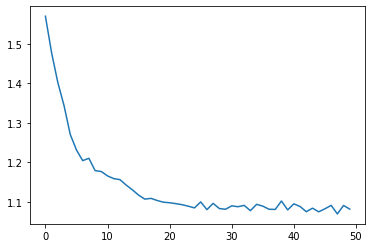

In [ ]:
# Define the optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(),lr = 0.001)
epochs = 50
device = 'cuda'
resnet50.to(device)
loss_epoch_list = []

for epoch in range(epochs):
    train_loss_epoch, train_accuracy_epoch = train(device, train_loader, resnet50, criterion, optimizer)

    print(f"Epoch [{epoch}/{epochs}]\t Train Loss: {train_loss_epoch / len(train_loader)}\t Train Accuracy: {train_accuracy_epoch / len(train_loader)}")

    loss_epoch, accuracy_epoch = validate(device, val_loader, resnet50)
    print(f"[Validation]\t Loss: {loss_epoch / len(val_loader)}\t Accuracy: {accuracy_epoch / len(val_loader)}")
    loss_epoch_list.append(loss_epoch)
print("Training successfully completed")



# final testing
loss_epoch, accuracy_epoch = test(device, test_loader,resnet50)
print(f"[FINAL]\t Loss: {loss_epoch / len(test_loader)}\t Accuracy: {accuracy_epoch / len(test_loader)}")
plt.plot(loss_epoch_list)

In [ ]:
#Saving the Models
torch.save(resnet50, '/content/drive/My Drive/Action_Recognition/Models/resnet50_1.pth')

In [ ]:
loss_epoch, accuracy_epoch = validate(device, val_loader, resnet50)
print(f"[FINAL]\t Loss: {loss_epoch / len(val_loader)}\t Accuracy: {accuracy_epoch / len(val_loader)}")

[FINAL]	 Loss: 1.0811713933944702	 Accuracy: 0.8695652173913043


In [ ]:
loss_epoch, accuracy_epoch = test(device, test_loader,resnet50)
print(f"[FINAL]\t Loss: {loss_epoch / len(test_loader)}\t Accuracy: {accuracy_epoch / len(test_loader)}")

[FINAL]	 Loss: 1.0731583833694458	 Accuracy: 0.875
